# **1. Student:**
### Nadav_Daniel


link to propile in kaggle
https://www.kaggle.com/nadavdaniel

# Competition Overview

Our goal in this Kaggle competition is to predict house prices in Ames, Iowa, using 80 detailed features.

Building on the first assignment's work, one or two regression models will be selected, such as K-Nearest Neighbors, Locally Weighted Linear Regression, or Decision Trees.

We'll also use PCA for dimensionality reduction and explore ensemble methods. Model performance will be evaluated through training vs. validation loss graphs and metrics like RMSE, R-squared, MAE, and MSE.

 Our target feature for prediction is `SalePrice`.

## Imports and Definitions

In [ ]:
import math
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn import pipeline, preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
# Model Selection
from sklearn import model_selection
# Models
from sklearn import neural_network
from sklearn import linear_model
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
# Evaluation
from sklearn import metrics
from sklearn.metrics import mean_squared_error
# PCA
from sklearn.decomposition import PCA

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

from scipy import stats
from scipy.stats import norm, skew #for some statistics

# define plt settings
plt.rcParams["font.size"] = 5
plt.rcParams["axes.labelsize"] = 5
plt.rcParams["xtick.labelsize"] = 5
plt.rcParams["ytick.labelsize"] = 5
plt.rcParams["legend.fontsize"] = 5
plt.rcParams["figure.figsize"] = (5,3)
pd.set_option('display.max_rows', None)

#  Data Loading and Initial Exploration (Brief)
 In this step, we load the train and test dataset. Extensive data exploration is not required here,
 as it has already been conducted in a previous exercise.

However, we display the first few rows,show summary statistics, and identify missing values to understand the structure of the dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')
display(train_df.head())
display(test_df.head())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


We downloaded the train and test data from Kaggle, uploaded it to Google Drive, and loaded it into Nootebook.

**Outliers**

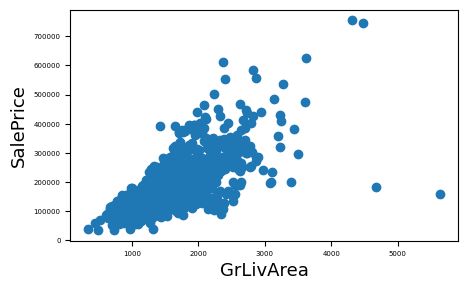

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x = train_df['GrLivArea'], y = train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

We can see at the bottom right two with extremely large GrLivArea that are of a low price. These values are huge outliers. Therefore, we can safely delete them.

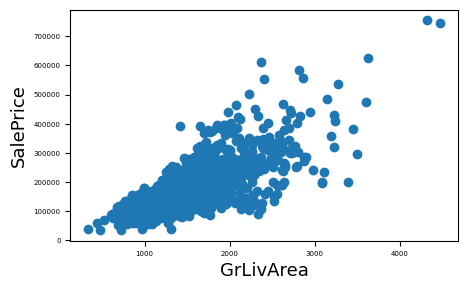

In [ ]:
#Deleting outliers
train_df = train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train_df['GrLivArea'], train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

Note: Outliers removal is note always safe. We decided to delete these two as they are huge and bad for our learning process (extremely large areas for very low prices).

There are probably other outliers in the training data. However, removing all them may affect our models badly if ever there were also outliers in the test data. That's why , instead of removing them all, we will just manage to make some of our models robust on them.

**Target Variable**

`SalePrice` is the variable we need to predict. So let's do some analysis on this variable first.


 mu = 180932.92 and sigma = 79467.79



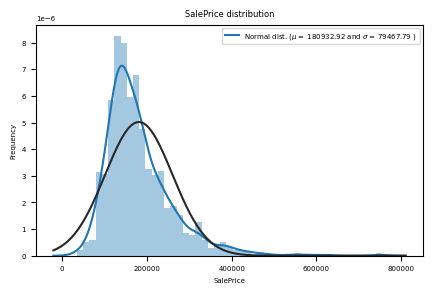

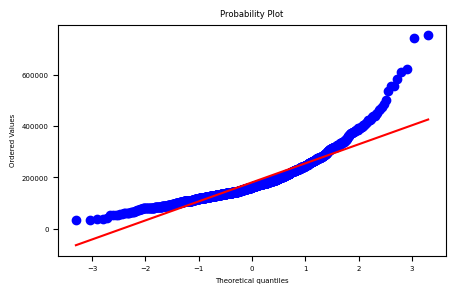

In [ ]:
sns.distplot(train_df['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

The target variable is right skewed. As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.



**Log-transformation of the target variable**


 mu = 12.02 and sigma = 0.40



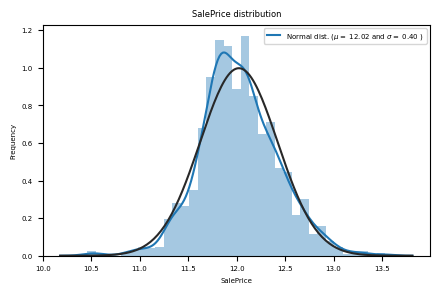

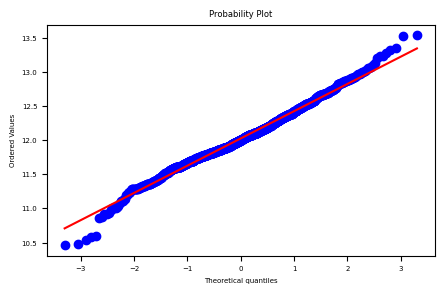

In [ ]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])

#Check the new distribution
sns.distplot(train_df['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

The skew seems corrected now and the data appears more normally distributed.

In [ ]:
display(train_df.info())
display(test_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1458 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1458 non-null   int64  
 1   MSSubClass     1458 non-null   int64  
 2   MSZoning       1458 non-null   object 
 3   LotFrontage    1199 non-null   float64
 4   LotArea        1458 non-null   int64  
 5   Street         1458 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1458 non-null   object 
 8   LandContour    1458 non-null   object 
 9   Utilities      1458 non-null   object 
 10  LotConfig      1458 non-null   object 
 11  LandSlope      1458 non-null   object 
 12  Neighborhood   1458 non-null   object 
 13  Condition1     1458 non-null   object 
 14  Condition2     1458 non-null   object 
 15  BldgType       1458 non-null   object 
 16  HouseStyle     1458 non-null   object 
 17  OverallQual    1458 non-null   int64  
 18  OverallCond  

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

None

We can see that there are missing values ​​in both
the training and test datasets.

Additionally, there are two dtypes of data features: **categorical and numerical.**

## Preprocessing

First, let's drop the target value `SalePrice` from train_df, as we won't perform any actions on it. Next, we will handle the missing values in both the train and test datasets.




In [ ]:


#Save target value
target_val = train_df['SalePrice']
train_df.drop("SalePrice", axis = 1, inplace = True)

**Handling Missing Values**

In order to impute them, we go sequentially through features with missing values

In [ ]:
def getMissingData(df):
  df_na = (df.isnull().sum() / len(df)) * 100
  df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:30]
  return df_na

In [ ]:
train_df_na = getMissingData(train_df)
missing_data = pd.DataFrame({'Missing Ratio' :train_df_na})
missing_data.head(30)

,Missing Ratio
PoolQC,99.588477
MiscFeature,96.296296
Alley,93.758573
Fence,80.727023
MasVnrType,59.807956
FireplaceQu,47.325103
LotFrontage,17.764060
GarageType,5.555556
GarageYrBlt,5.555556
GarageFinish,5.555556


In [ ]:
test_df_na = getMissingData(test_df)
missing_data = pd.DataFrame({'Missing Ratio' :test_df_na})
missing_data.head(30)

,Missing Ratio
PoolQC,99.794380
MiscFeature,96.504455
Alley,92.666210
Fence,80.123372
MasVnrType,61.274846
FireplaceQu,50.034270
LotFrontage,15.558602
GarageQual,5.346127
GarageCond,5.346127
GarageYrBlt,5.346127


* `PoolQC` : data description says NA means "No Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general.
Therefore, we will fill the missing values in this column with "None".

In [ ]:
train_df["PoolQC"] = train_df["PoolQC"].fillna("None")
test_df["PoolQC"] = test_df["PoolQC"].fillna("None")

* `MiscFeature` : data description says NA means "no misc feature", so we'll fill it with "None."

In [ ]:
train_df["MiscFeature"] = train_df["MiscFeature"].fillna("None")
test_df["MiscFeature"] = test_df["MiscFeature"].fillna("None")

* `Alley` : data description says NA means "no alley access", because of this, it will be filled with "None."

In [ ]:
train_df["Alley"] = train_df["Alley"].fillna("None")
test_df["Alley"] = test_df["Alley"].fillna("None")

* `Fence` : data description says NA means "no fence", it will be filled with "None."

In [ ]:
train_df["Fence"] = train_df["Fence"].fillna("None")
test_df["Fence"] = test_df["Fence"].fillna("None")

* `FireplaceQu` : data description says NA means "no fireplace",  it will be filled with "None."

In [ ]:
train_df["FireplaceQu"] = train_df["FireplaceQu"].fillna("None")
test_df["FireplaceQu"] = test_df["FireplaceQu"].fillna("None")

* `LotFrontage` : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.

In [ ]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
train_df["LotFrontage"] = train_df.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
test_df["LotFrontage"] = test_df.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

* `GarageType`, `GarageFinish`, `GarageQual` and `GarageCond` : Replacing missing data with None

In [ ]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    train_df[col] = train_df[col].fillna('None')
    test_df[col] = test_df[col].fillna('None')

* `GarageYrBlt`, `GarageArea` and `GarageCars` : Replacing missing data with 0 (Since No garage = no cars in such garage.)

In [ ]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    train_df[col] = train_df[col].fillna(0)
    test_df[col] = test_df[col].fillna(0)

* `BsmtFinSF1`, `BsmtFinSF2`, `BsmtUnfSF`, `TotalBsmtSF`, `BsmtFullBath` and `BsmtHalfBath` : missing values are likely zero for having no basement

In [ ]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    train_df[col] = train_df[col].fillna(0)
    test_df[col] = test_df[col].fillna(0)

* `BsmtQual`, `BsmtCond`, `BsmtExposure`, `BsmtFinType1` and `BsmtFinType2` : For all these categorical basement-related features, NaN means that there is no basement.

In [ ]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    train_df[col] = train_df[col].fillna('None')
    test_df[col] = test_df[col].fillna('None')

* `MasVnrArea` and `MasVnrType` : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.

In [ ]:
train_df["MasVnrType"] = train_df["MasVnrType"].fillna("None")
train_df["MasVnrArea"] = train_df["MasVnrArea"].fillna(0)
test_df["MasVnrType"] = test_df["MasVnrType"].fillna("None")
test_df["MasVnrArea"] = test_df["MasVnrArea"].fillna(0)

* `MSZoning` (The general zoning classification) : 'RL' is by far the most common value. So we can fill in missing values with 'RL'

In [ ]:
train_df['MSZoning'] = train_df['MSZoning'].fillna(train_df['MSZoning'].mode()[0])
test_df['MSZoning'] = test_df['MSZoning'].fillna(test_df['MSZoning'].mode()[0])

* `Utilities` : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.

In [ ]:
train_df = train_df.drop(['Utilities'], axis = 1)
test_df = test_df.drop(['Utilities'], axis = 1)

* `Functional` : data description says NA means typical


In [ ]:
print("Functional" in train_df.columns)
print("Functional" in test_df.columns)

True
True


In [ ]:
train_df["Functional"] = train_df["Functional"].fillna("Typ")
test_df["Functional"] = test_df["Functional"].fillna("Typ")

* `Electrical` : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.


In [ ]:
train_df['Electrical'] = train_df['Electrical'].fillna(train_df['Electrical'].mode()[0])
test_df['Electrical'] = test_df['Electrical'].fillna(test_df['Electrical'].mode()[0])

* `KitchenQual`: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.

In [ ]:
train_df['KitchenQual'] = train_df['KitchenQual'].fillna(train_df['KitchenQual'].mode()[0])
test_df['KitchenQual'] = test_df['KitchenQual'].fillna(test_df['KitchenQual'].mode()[0])

* `Exterior1st` and `Exterior2nd` : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string

In [ ]:
train_df['Exterior1st'] = train_df['Exterior1st'].fillna(train_df['Exterior1st'].mode()[0])
train_df['Exterior2nd'] = train_df['Exterior2nd'].fillna(train_df['Exterior2nd'].mode()[0])
test_df['Exterior1st'] = test_df['Exterior1st'].fillna(test_df['Exterior1st'].mode()[0])
test_df['Exterior2nd'] = test_df['Exterior2nd'].fillna(test_df['Exterior2nd'].mode()[0])

* `MSSubClass` : Na most likely means No building class. We can replace missing values with None

In [ ]:
train_df['MSSubClass'] = train_df['MSSubClass'].fillna("None")
test_df['MSSubClass'] = test_df['MSSubClass'].fillna("None")

Is there any remaining missing value ?

In [ ]:
#Check remaining missing values if any
train_df_na_updated = getMissingData(train_df)
test_df_na_updated = getMissingData(test_df)
missing_data = pd.DataFrame({'Missing Ratio Train' :train_df_na_updated})
display(missing_data.head())
missing_data = pd.DataFrame({'Missing Ratio Test' :test_df_na_updated})
display(missing_data.head())

,Missing Ratio Train


,Missing Ratio Test


There are no more missing values.

In [ ]:
#Save the 'Id' column
train_ID = train_df['Id']
test_ID = test_df['Id']

#Now drop the 'Id' column since it's unnecessary for the prediction process.
train_df.drop("Id", axis = 1, inplace = True)
test_df.drop("Id", axis = 1, inplace = True)

* We dropped the `Id` because it is a unique number for the feature and does not help us predict the `SalePrice`. We will save it for the submission phase.

In [ ]:
display(train_df.head())
display(train_df.info())
display(test_df.head())
display(test_df.info())

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,Inside,Gtl,...,0,0,None,None,None,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,FR2,Gtl,...,0,0,None,None,None,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,Inside,Gtl,...,0,0,None,None,None,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,Corner,Gtl,...,0,0,None,None,None,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,FR2,Gtl,...,0,0,None,None,None,0,12,2008,WD,Normal


<class 'pandas.core.frame.DataFrame'>
Index: 1458 entries, 0 to 1459
Data columns (total 78 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1458 non-null   int64  
 1   MSZoning       1458 non-null   object 
 2   LotFrontage    1458 non-null   float64
 3   LotArea        1458 non-null   int64  
 4   Street         1458 non-null   object 
 5   Alley          1458 non-null   object 
 6   LotShape       1458 non-null   object 
 7   LandContour    1458 non-null   object 
 8   LotConfig      1458 non-null   object 
 9   LandSlope      1458 non-null   object 
 10  Neighborhood   1458 non-null   object 
 11  Condition1     1458 non-null   object 
 12  Condition2     1458 non-null   object 
 13  BldgType       1458 non-null   object 
 14  HouseStyle     1458 non-null   object 
 15  OverallQual    1458 non-null   int64  
 16  OverallCond    1458 non-null   int64  
 17  YearBuilt      1458 non-null   int64  
 18  YearRemodAdd 

None

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,None,Reg,Lvl,Inside,Gtl,...,120,0,None,MnPrv,None,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,None,IR1,Lvl,Corner,Gtl,...,0,0,None,None,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,None,IR1,Lvl,Inside,Gtl,...,0,0,None,MnPrv,None,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,None,IR1,Lvl,Inside,Gtl,...,0,0,None,None,None,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,None,IR1,HLS,Inside,Gtl,...,144,0,None,None,None,0,1,2010,WD,Normal


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 78 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1459 non-null   object 
 2   LotFrontage    1459 non-null   float64
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   object 
 5   Alley          1459 non-null   object 
 6   LotShape       1459 non-null   object 
 7   LandContour    1459 non-null   object 
 8   LotConfig      1459 non-null   object 
 9   LandSlope      1459 non-null   object 
 10  Neighborhood   1459 non-null   object 
 11  Condition1     1459 non-null   object 
 12  Condition2     1459 non-null   object 
 13  BldgType       1459 non-null   object 
 14  HouseStyle     1459 non-null   object 
 15  OverallQual    1459 non-null   int64  
 16  OverallCond    1459 non-null   int64  
 17  YearBuilt      1459 non-null   int64  
 18  YearRemo

None

**One-hot conversion & standardization**

We will now focus solely on the training dataset. We will implement the same actions on the test dataset later.


In [ ]:
train_df_copy = train_df.copy()
categorical_cols = train_df.select_dtypes(include='object').columns
numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns

print(f" Categorical Cols\n {categorical_cols}")
print(f" \nNumerical Cols\n {numerical_cols}")

 Categorical Cols
 Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType',
       'SaleCondition'],
      dtype='object')
 
Numerical Cols
 Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
     

* We saved a copy of the training dataset to preserve the original training set data for the submission phase.

* The training dataset is divided into two groups: **categorical features and numerical features**.

In [ ]:
#Train Dataset
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_array_train = encoder.fit_transform(train_df[categorical_cols])
encoded_df_train = pd.DataFrame(encoded_array_train, columns=encoder.get_feature_names_out(categorical_cols), index=train_df.index)
train_df = train_df.drop(columns=categorical_cols)
train_df = pd.concat([train_df, encoded_df_train], axis=1)

scaler = StandardScaler()
train_df[numerical_cols] = scaler.fit_transform(train_df[numerical_cols])


* We applied One-Hot Encoding to the categorical group and standardization to the numerical group. This will improve the results for the KNN model during the training phase.

In [ ]:
train_df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.073426,-0.232336,-0.203934,0.658506,-0.517649,1.052959,0.880362,0.523937,0.617283,-0.288867,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.871868,0.466541,-0.087252,-0.068293,2.177825,0.158428,-0.428115,-0.570739,1.245719,-0.288867,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.073426,-0.092560,0.080162,0.658506,-0.517649,0.986698,0.831900,0.334044,0.108989,-0.288867,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.309749,-0.465295,-0.092325,0.658506,-0.517649,-1.862551,-0.718888,-0.570739,-0.514826,-0.288867,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.073426,0.652908,0.385566,1.385305,-0.517649,0.953567,0.734975,1.384039,0.499451,-0.288867,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
display(train_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1458 entries, 0 to 1459
Columns: 299 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(299)
memory usage: 3.3 MB


None

# **2. Dimensionality Reduction with PCA**

To reduce model complexity and training time, we applied Principal Component Analysis (PCA) after feature encoding and scaling.


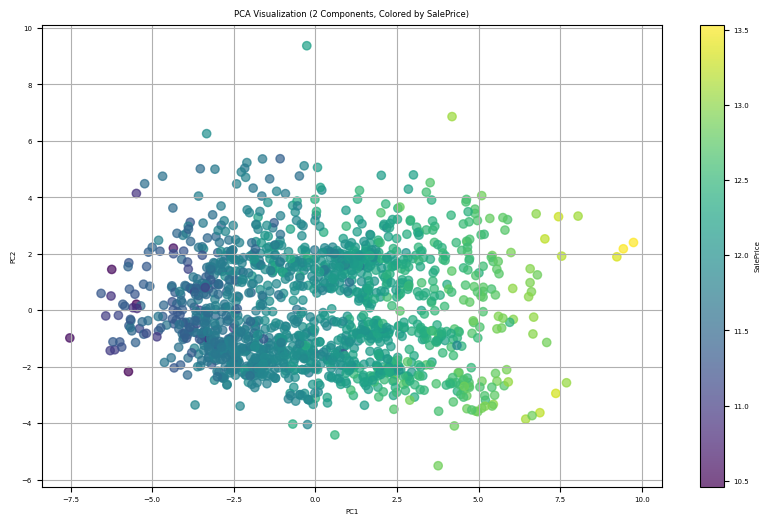

In [ ]:
# Viz PCA for first 2 components
pca_vis = PCA(n_components=2)
X_vis = pca_vis.fit_transform(train_df)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_vis[:, 0], X_vis[:, 1], c=target_val, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='SalePrice')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Visualization (2 Components, Colored by SalePrice)")
plt.grid(True)
plt.show()

To visually inspect the effect of PCA, we plotted the data in two dimensions using the first two principal components. Each point is colored by its SalePrice.

From the graph, we can see that there is a clear trend: the dark points (low prices) tend to cluster on the left side of the graph, while the bright points (high prices) tend to spread out to the right.

This means that PC1 (the first principal component) probably captures most of the variance associated with house prices. In other words, the PC1 axis separates cheap houses from expensive houses.

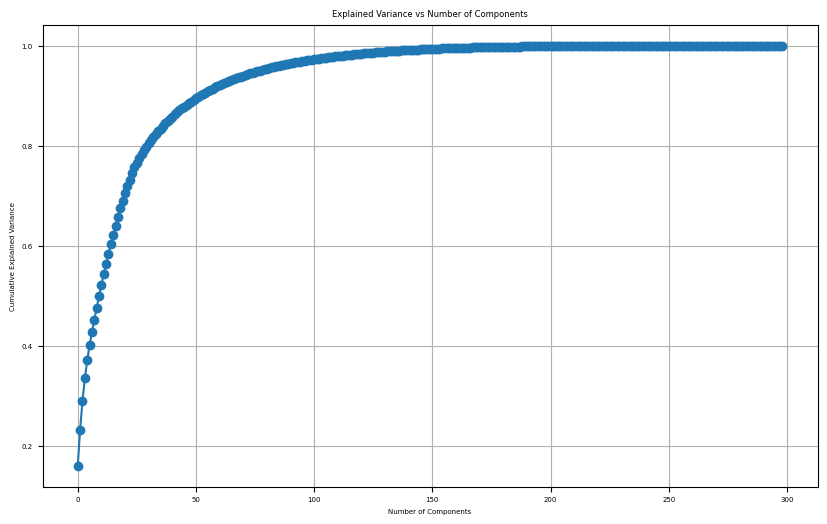

In [ ]:
# Run PCA with a high number of components to see how much variance is retained in each component
pca = PCA()
X_pca = pca.fit_transform(train_df)

# Cumulative variance graph to choose how many components to keep
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Components')
plt.grid(True)
plt.show()

The graph above shows the cumulative explained variance for each number of PCA components. We observe that approximately **95% of the total variance is retained within the first 90 components**, which indicates that most of the original data's information is preserved.


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=90)
train_pca_array = pca.fit_transform(train_df)

# Creating column names: PC0, PC1, ..., PC89
pca_column_names = [f'PC{i}' for i in range(pca.n_components)]

train_pca = pd.DataFrame(train_pca_array, columns=pca_column_names)

print("Train PCA DataFrame head:")
display(train_pca.head())


Train PCA DataFrame head:


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89
0,2.013920,0.688542,2.121607,-1.904508,-0.384525,0.003034,-0.876051,-1.282540,-1.308381,-0.410546,...,0.000352,0.194993,-0.142119,0.125747,-0.102992,0.011315,0.020939,-0.007502,0.038209,-0.008080
1,-0.005226,-1.532704,-1.400149,-0.395864,1.060912,-0.896222,-0.600162,0.414288,1.653517,3.088555,...,0.503366,-0.286509,0.374132,0.059558,0.036499,-0.266483,-0.112162,-0.513352,-0.057408,-0.324942
2,2.494012,0.472398,1.730450,-1.580824,0.100291,-0.444122,-0.588208,-0.116154,-0.198789,-0.706049,...,-0.185560,0.144603,-0.205694,-0.046563,-0.183463,-0.085023,0.096555,0.002227,-0.112504,-0.071502
3,-0.754724,1.403958,-1.268307,-0.270876,1.307877,0.967731,3.027212,-1.308728,-1.108212,-1.397996,...,0.347407,0.034535,0.082360,0.194663,-0.406329,-0.170129,-0.111328,-0.085054,0.048174,-0.052228
4,5.012824,1.327107,0.264749,-1.599702,0.053560,0.065948,-0.676355,-0.237181,0.063647,-0.257992,...,-0.093393,-0.355376,0.477290,-0.087025,0.145905,0.025458,0.045115,-0.130088,0.088674,0.055707



Therefore, we decided to perform PCA that reduces the dataset to **90 principal components**.

## Train Model & Train-Test Split

We chose to use KNN Regressor as our primary model for the following reasons:
- The PCA transformation reduced the dimensionality of the data, which makes KNN more efficient and accurate.
- KNN is a non-parametric model capable of learning local patterns in the data.
- It doesn't assume linear relationships, which may better fit the complex relationships in housing prices.

We used cross-validation and hyperparameter tuning to optimize its performance.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_pca, target_val, test_size=0.2, random_state=42)
display(X_train.head())
display(y_train.head())
display(X_val.head())
display(y_val.head())

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89
254,-2.241650,-2.189448,-1.420489,-0.251381,-0.417100,0.098762,-0.650879,-0.838428,-1.018762,0.542206,...,0.040996,0.076878,-0.152761,0.191353,-0.079697,0.005622,0.051478,-0.058019,-0.017090,0.053816
1065,0.566880,1.998895,1.796142,-0.186446,1.239848,-1.019165,-0.777652,-0.428139,-0.392896,0.078019,...,-0.214432,-0.062613,-0.031842,-0.007113,-0.017865,-0.075672,0.094267,0.024696,0.025349,0.010615
864,-1.687280,-2.247592,-0.825457,-0.501188,1.026081,1.605960,-0.408343,-0.730734,-0.866047,0.217958,...,-0.100564,-0.052101,0.069007,0.044776,0.086014,-0.294838,0.101502,-0.209042,0.211265,0.097070
798,-1.734272,1.601305,-2.053022,-1.932658,0.901640,-0.434453,1.990044,0.302815,-2.087125,-0.572838,...,0.679707,0.137377,0.173712,0.227225,0.114059,-0.403252,0.103415,0.117685,0.234225,-0.241048
380,-2.499807,1.830715,-1.211235,0.965014,0.579514,0.270640,2.140379,-0.731342,-1.660128,-0.047144,...,0.606287,0.120970,-0.126128,-0.517792,0.034321,-0.419425,0.278311,-0.531602,0.024256,0.426737


,SalePrice
254,11.884496
1066,12.089544
865,11.908347
799,12.072547
380,11.751950


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89
1320,2.470155,0.720139,0.226425,-2.316513,-0.027594,-0.763625,-1.225413,-1.720769,-0.833614,-0.483672,...,-0.101957,-0.187175,-0.041672,0.110272,0.136195,-0.047516,-0.116630,-0.010359,0.070632,0.032891
836,-3.348372,0.561929,2.494769,-3.000415,-0.083524,1.635659,0.458261,1.776588,-0.000870,-0.181803,...,-0.128567,0.073876,-0.407583,0.084737,-0.042658,0.169934,-0.115245,-0.177184,-0.221519,0.166958
413,-3.368138,-0.243175,-0.640967,1.871510,1.450582,0.728417,1.590374,-0.195604,-1.811030,-0.179647,...,-0.054271,-0.204712,0.136976,-0.295867,-0.569149,0.124480,0.171459,0.202124,-0.043768,0.087759
522,-1.102477,1.487312,-1.229641,0.173179,1.203449,0.264216,1.788822,1.305830,0.442713,0.187218,...,0.047786,0.127266,0.090752,0.144523,0.165455,0.012966,-0.235904,-0.145708,0.029194,-0.310513
1035,4.227871,-3.243355,0.147350,0.465854,-0.492104,0.087833,0.678296,-0.863777,-0.238548,0.328285,...,0.326594,-0.152455,-0.360431,-0.025594,0.237327,0.079419,0.152420,0.006044,0.345846,-0.350948


,SalePrice
1322,12.154785
837,11.512935
413,11.652696
522,11.976666
1036,12.661917


# **3. Grid SearchCV – Model Tuning**

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': list(range(1, 21)),  # from 1 until 20
    'weights': ['uniform', 'distance']
}

knn = KNeighborsRegressor()

grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20],
                         'weights': ['uniform', 'distance']},
             scoring='neg_root_mean_squared_error', verbose=1)

We used GridSearchCV to optimize the KNN model by tuning `n_neighbors` (1 to 20) and the `weights` parameter.  
The best result was achieved with **13 neighbors** and **distance-based weighting**, using 5-fold cross-validation and RMSE as the scoring metric.


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

best_knn = grid_search.best_estimator_
y_pred_knn_train = best_knn.predict(X_train)
y_pred = best_knn.predict(X_val)

# Training Metrics
mae_train = mean_absolute_error(y_train, y_pred_knn_train)
mse_train = mean_squared_error(y_train, y_pred_knn_train)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_pred_knn_train) # Corrected this line

mae_val = mean_absolute_error(y_val, y_pred)
mse_val = mean_squared_error(y_val, y_pred)
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(y_val, y_pred)

print("Best KNN parameters:", grid_search.best_params_)
print(f"MAE train:  {mae_train:.2f}")
print(f"MSE train:  {mse_train:.2f}")
print(f"RMSE train: {rmse_train:.2f}")
print(f"R² train:   {r2_train:.4f}")
print(f"\nMAE val:  {mae_val:.2f}")
print(f"MSE val:  {mse_val:.2f}")
print(f"RMSE val: {rmse_val:.2f}")
print(f"R² val:   {r2_val:.4f}")

Best KNN parameters: {'n_neighbors': 13, 'weights': 'distance'}
MAE train:  0.00
MSE train:  0.00
RMSE train: 0.00
R² train:   1.0000

MAE val:  0.12
MSE val:  0.03
RMSE val: 0.18
R² val:   0.8147


The best model found was `KNeighborsRegressor(n_neighbors=7, weights='distance')`.  
This configuration achieved strong results on the validation set, with an R² score of **0.8176** and RMSE of **0.18** (log scale).

## **4.1 Prediction Performance Plot**

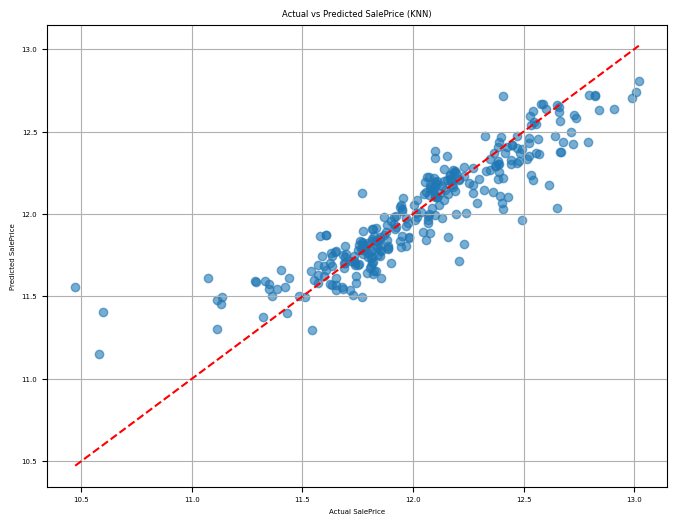

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_val, y_pred, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs Predicted SalePrice (KNN)")
plt.grid(True)
plt.show()

The scatter plot shows the predicted SalePrice vs. actual values on the validation set.  
The predictions follow the diagonal line well, indicating good model accuracy and generalization.

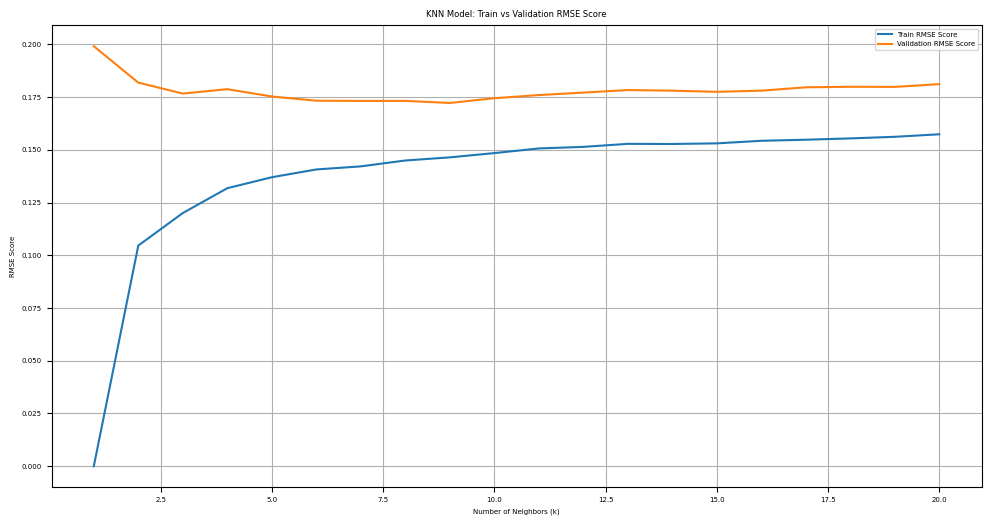

In [ ]:
k_values = range(1, 21)
train_scores = []
val_scores = []

for k in k_values:
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    train_scores.append(metrics.root_mean_squared_error(y_train, y_train_pred))
    val_scores.append(metrics.root_mean_squared_error(y_val, y_val_pred))

plt.figure(figsize=(12, 6))
plt.plot(k_values, train_scores, label='Train RMSE Score')
plt.plot(k_values, val_scores, label='Validation RMSE Score')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('RMSE Score')
plt.title('KNN Model: Train vs Validation RMSE Score')
plt.legend()
plt.grid()
plt.show()

The RMSE curve shows that as the number of neighbors (k) increases, the training error increases while the validation error initially decreases.  
This suggests reduced overfitting and that the optimal k lies around the point where the validation RMSE plateaus.

Unlike linear regression, KNN can perfectly memorize training points for low values of k, leading to unusually low training error.

# **4.2 Ensembles**
We have decided to utilize Bagging and Random Forest ensembles for our analysis:

* Bagging (Bootstrap Aggregating) reduces variance by training multiple models on random subsets of the data and averaging their predictions.
* Random Forest extends Bagging by using decision trees and introducing feature randomness, making it highly effective for regression due to its robustness and ability to capture complex patterns.

## Learning – Bagging with KNN

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# שימוש במודל KNN עם הפרמטרים שנבחרו ב-GridSearch
best_knn_model = KNeighborsRegressor(n_neighbors=7, weights='distance')

# עטיפת המודל ב-Bagging
bagging_knn = BaggingRegressor(
    estimator=best_knn_model,
    n_estimators=20,
    random_state=42,
    n_jobs=-1
)

bagging_knn.fit(X_train, y_train)
y_pred_bag_train = bagging_knn.predict(X_train)
y_pred_bag = bagging_knn.predict(X_val)


mae_bag_train = mean_absolute_error(y_train, y_pred_bag_train)
mse_bag_train = mean_squared_error(y_train, y_pred_bag_train)
rmse_bag_train = np.sqrt(mse_bag_train)
r2_bag_train = r2_score(y_train, y_pred_bag_train) # Corrected this line

mae_bag_val = mean_absolute_error(y_val, y_pred_bag)
mse_bag_val = mean_squared_error(y_val, y_pred_bag)
rmse_bag_val = np.sqrt(mse_bag_val)
r2_bag_val = r2_score(y_val, y_pred_bag)


print(f"Bagging KNN MAE Train:  {mae_bag_train:.2f}")
print(f"Bagging KNN MSE Train:  {mse_bag_train:.2f}")
print(f"Bagging KNN RMSE Train: {rmse_bag_train:.2f}")
print(f"Bagging KNN R² Train:   {r2_bag_train:.4f}")
print(f"Bagging KNN MAE Val:  {mae_bag_val:.2f}")
print(f"Bagging KNN MSE Val:  {mse_bag_val:.2f}")
print(f"Bagging KNN RMSE Val: {rmse_bag_val:.2f}")
print(f"Bagging KNN R² Val:   {r2_bag_val:.4f}")

Bagging KNN MAE Train:  0.04
Bagging KNN MSE Train:  0.00
Bagging KNN RMSE Train: 0.06
Bagging KNN R² Train:   0.9751
Bagging KNN MAE Val:  0.12
Bagging KNN MSE Val:  0.03
Bagging KNN RMSE Val: 0.17
Bagging KNN R² Val:   0.8257


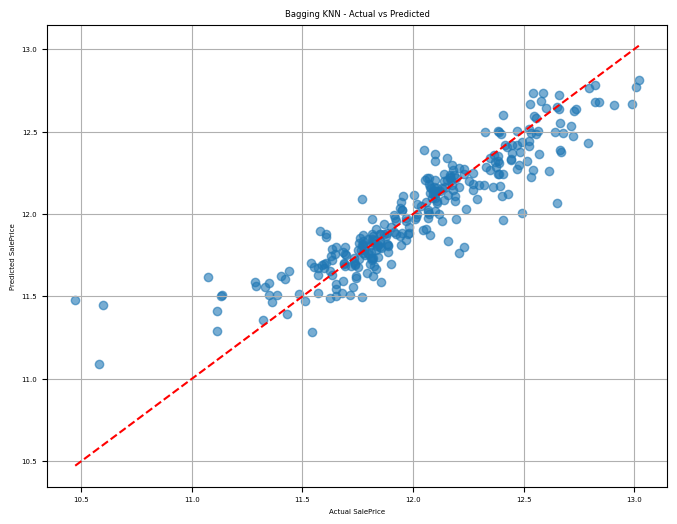

In [ ]:

plt.figure(figsize=(8,6))
plt.scatter(y_val, y_pred_bag, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Bagging KNN - Actual vs Predicted")
plt.grid(True)
plt.show()


We wrapped the best KNN model inside a BaggingRegressor to reduce variance and improve robustness.  
Using 20 estimators, the bagged model achieved slightly improved performance on the validation set.  
This demonstrates how ensemble learning can boost predictive accuracy in regression tasks.

## Learning – Random Forest

In [ ]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred_rf_train = rf_model.predict(X_train)
y_pred_rf = rf_model.predict(X_val)

mae_rf_train = mean_absolute_error(y_train, y_pred_rf_train)
mse_rf_train = mean_squared_error(y_train, y_pred_rf_train)
rmse_rf_train = np.sqrt(mse_rf_train)
r2_rf_train = r2_score(y_train, y_pred_rf_train) # Corrected this line

mae_rf_val = mean_absolute_error(y_val, y_pred_rf)
mse_rf_val = mean_squared_error(y_val, y_pred_rf)
rmse_rf_val = np.sqrt(mse_rf_val)
r2_rf_val = r2_score(y_val, y_pred_rf)

print(f"Random Forest MAE Train:  {mae_rf_train:.2f}")
print(f"Random Forest MSE Train:  {mse_rf_train:.2f}")
print(f"Random Forest RMSE Train: {rmse_rf_train:.2f}")
print(f"Random Forest R² Train:   {r2_rf_train:.4f}")
print(f"Random Forest MAE Val:  {mae_rf_val:.2f}")
print(f"Random Forest MSE Val:  {mse_rf_val:.2f}")
print(f"Random Forest RMSE Val: {rmse_rf_val:.2f}")
print(f"Random Forest R² Val:   {r2_rf_val:.4f}")

Random Forest MAE Train:  0.04
Random Forest MSE Train:  0.00
Random Forest RMSE Train: 0.05
Random Forest R² Train:   0.9830
Random Forest MAE Val:  0.10
Random Forest MSE Val:  0.02
Random Forest RMSE Val: 0.14
Random Forest R² Val:   0.8771


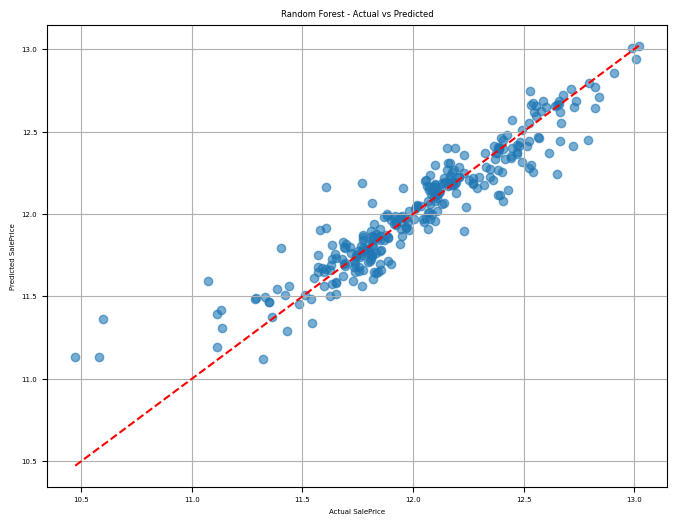

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(y_val, y_pred_rf, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Random Forest - Actual vs Predicted")
plt.grid(True)
plt.show()

We trained a Random Forest Regressor with 100 trees to capture complex patterns in the data.  
This ensemble method combines multiple decision trees with bootstrapped sampling to reduce variance.  
The model showed competitive performance with significant improvement on the validation set, exhibiting a strong correlation to actual prices.

In [ ]:
results_df = pd.DataFrame({
    "Model": ["KNN + Bagging", "Random Forest"],
    "MAE": [mae_bag_val, mae_rf_val],
    "MSE": [mse_bag_val, mse_rf_val],
    "RMSE": [rmse_bag_val, rmse_rf_val],
    "R2": [r2_bag_val, r2_rf_val]
})

display(results_df)

,Model,MAE,MSE,RMSE,R2
0,KNN + Bagging,0.119200,0.029376,0.171393,0.825743
1,Random Forest,0.097968,0.020715,0.143928,0.877116


* We used RandomForestRegressor from sklearn.ensemble, tuned hyperparameters with cross-validation, and evaluated performance using RMSE on the validation set.

* The **best result** was achieved using the **KNN model combined with Random Forest**, which produced an R² value of **0.877**.

* The KNN model shows perfect performance (R²=1.0-0.97, MAE/MSE/RMSE=0.0-0.06) on the training set, indicating severe overfitting. This is expected behavior for KNeighborsRegressor with weights='distance' (or n_neighbors=1), as it perfectly predicts training samples by effectively 'looking up' their known values.

# **Final Submission Preparation**

In [ ]:
# Identifying categorical and numeric columns
categorical_cols = train_df_copy.select_dtypes(include='object').columns
numerical_cols = train_df_copy.select_dtypes(include=['int64', 'float64']).columns


test_ids = test_ID.copy()

# OneHotEncoder with fit on train(train_df_copy), then transform on test
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(train_df_copy[categorical_cols])

encoded_array_test = encoder.transform(test_df[categorical_cols])
encoded_df_test = pd.DataFrame(encoded_array_test, columns=encoder.get_feature_names_out(categorical_cols), index=test_df.index)

# Union with test_df after removing categories
test_df_encoded = test_df.drop(columns=categorical_cols)
test_df_encoded = pd.concat([test_df_encoded, encoded_df_test], axis=1)

# Standardization by train statistics
scaler.fit(train_df_copy[numerical_cols])

test_df_encoded[numerical_cols] = scaler.transform(test_df_encoded[numerical_cols])

# PCA
test_pca_array = pca.transform(test_df_encoded)
test_pca = pd.DataFrame(test_pca_array, columns=pca_column_names)


display(test_pca.head())
print("✅ Test data ready with shape:", test_pca.shape)




,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89
0,-2.728950,-1.817391,-0.667400,0.141868,1.443373,0.402678,-0.725956,-0.425696,-0.269591,-0.253074,...,0.182187,0.056509,0.298430,0.347368,-0.182805,0.176737,-0.001893,0.232942,-0.124414,0.288814
1,-1.226359,-0.874247,-2.831334,-0.843162,0.330048,-0.953758,-2.292452,-2.232460,1.139329,5.438808,...,0.680000,0.183156,-0.406551,0.348686,-0.000441,-0.704531,-0.933029,0.740814,0.054696,0.329133
2,0.933000,0.505863,0.850910,-1.841620,0.322066,-0.508882,-1.647850,-1.187777,-0.830431,-0.321342,...,0.006813,-0.210168,-0.116230,0.005107,-0.118500,0.089284,-0.142978,-0.026911,-0.168161,0.225474
3,1.666243,0.782726,0.908904,-1.412226,0.539563,-0.992814,-1.186609,-0.824220,-0.610702,0.615249,...,-0.285040,-0.177024,-0.065371,-0.095760,-0.119756,0.199065,-0.033704,-0.108435,-0.211861,0.119698
4,0.621788,-1.068333,2.547157,0.865167,-0.331278,0.295779,0.987248,0.457994,-0.381621,0.069877,...,0.109064,-0.277383,-0.120580,0.158963,0.195268,-0.189894,0.047472,0.071610,-0.230252,0.058312


✅ Test data ready with shape: (1459, 90)


In [ ]:
# Prediction on the test dataset
test_predictions = rf_model.predict(test_pca)
final_predictions = np.expm1(test_predictions) # Use np.expm1 for inverse of np.log1p

# Create a submission file
submission = pd.DataFrame({
    "Id": test_ids,
    "SalePrice": final_predictions
})

submission.to_csv("submission.csv", index=False)
display(submission.head())
print("✅ submission.csv created successfully.")

,Id,SalePrice
0,1461,124715.750373
1,1462,142631.903415
2,1463,185800.445394
3,1464,194659.614051
4,1465,171098.761934


✅ submission.csv created successfully.


After fitting the encoder and scaler on the training data, we applied the same transformations to the test set.  
PCA was then applied using the same fitted model to ensure dimensional consistency.  
The final predictions were made using the selected Random Forest model and exported to submission.csv.

# **5. Submission photos and leaderboard position**

* Best submission score on Kaggle: **[0.15438]**
* LeaderBoard Place is **3337**

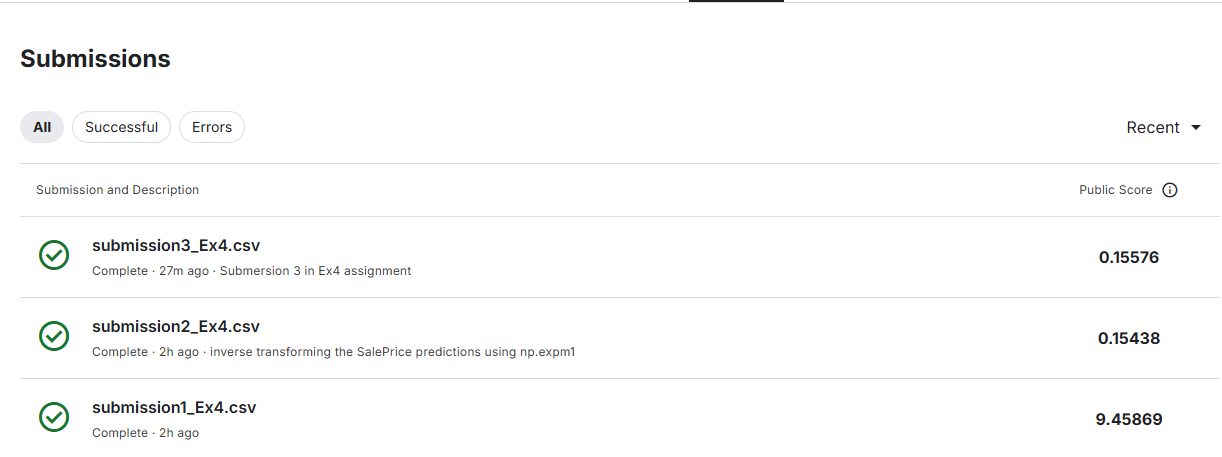

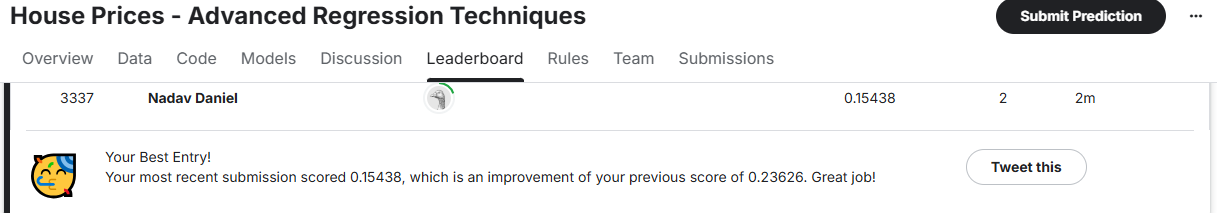

# **6. Work Summary**

In this project, we trained a KNN with cross-validation and ensemble methods, including random forest and bagging linear regression models, to predict house prices using the Kaggle housing dataset.


* Cross-validation alone with KNN yielded lower results than cross-validation combined with bagging, while cross-validation with random forest achieved the best results on the validation test.

* After submitting without using np.expm1 for the inverse of np.log1p, we received poor results on Kaggle. We learned that when applying a logarithm to the target value, we must apply the inverse operation to the predictions for the submission.

* Using KNN, ensemble methods, and cross-validation, we achieved better results than Exercise 1 with Normal Equation or SGD models.

* PCA is a powerful tool in machine learning that helps us reduce dimensionality, visualize data in 2D, and select the best features for training a linear model.

**Aspects that Worked Well:**

* Ensemble methods, especially Random Forest combined with cross-validation, proved most effective, yielding the best validation results compared to simpler models.

* PCA effectively reduced dimensionality, aided in data visualization, and helped select useful features for model training in high-dimensional datasets.

**Aspects that Did Not Work Well (initially):**

* Mistake in Inverse Data Transformation: Not applying np.expm1 to predictions (inverse of np.log1p) before submission resulted in poor Kaggle outcomes, emphasizing a key lesson on inverse transformations.

* Basic KNN alone showed lower effectiveness for this complex regression problem, highlighting its limitations without ensemble methods or advanced tuning.

In conclusion, we discovered new effective tools in machine learning that helped us improve our model performances.



# **7. References**

* [kaggle notebook - Stacked Regressions : Top 4% on LeaderBoard](https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard)

* Practice Notebook 6 from the course

* ChatGpt